# Setting up virtual environment

Install Mambaforge https://mamba.readthedocs.io/en/latest/installation.html
If you're on MacOS you can run `brew install mambaforge`

Create a virtual environment for the project
`mamba create -n fakenews python=3.10`

Activate the env `mamba activate fakenews`

Install dependencies we'll need for the project
`mamba install -c huggingface transformers=4.26.0 datasets evaluate jupyterlab scikit-learn`



Run jupyterlab:
`jupyter lab`

In [13]:
conda install pytorch

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Erick\anaconda3\envs\fakenews

  added / updated specs:
    - pytorch


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    future-0.18.2              |  py310haa95532_1         672 KB
    libuv-1.40.0               |       he774522_0         255 KB
    ninja-1.10.2               |       haa95532_5          14 KB
    ninja-base-1.10.2          |       h6d14046_5         255 KB
    pytorch-1.12.1             |cpu_py310h5e1f01c_0        80.7 MB
    ------------------------------------------------------------
                                           Total:        81.9 MB

The following NEW packages will be INSTALLED:

  future             pkgs/main/win-64::future-0.18.2-py310haa95532_1
  libuv              pkgs/main/win-64::libuv-1.40.0-he774522_0
  ninja              pkgs/main/win-64::ninja-1.10.2-h



==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

ModuleNotFoundError: No module named 'torch'

In [1]:
from datasets import load_dataset, load_from_disk

C:\Users\Erick\anaconda3\envs\fakenews\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("liar")

Found cached dataset liar (C:/Users/Erick/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514)
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 251.43it/s]


In [3]:
fake_csv = load_dataset("csv", data_files="news.csv")

Using custom data configuration default-16166e5dc31fa63c
Found cached dataset csv (C:/Users/Erick/.cache/huggingface/datasets/csv/default-16166e5dc31fa63c/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.26it/s]


In [4]:
fake_csv

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 6335
    })
})

In [5]:
fake_csv_split = fake_csv["train"].train_test_split(test_size=0.1)

In [6]:
fake_csv_split

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 5701
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 634
    })
})

In [7]:
from transformers import AutoTokenizer

# Load DistilBERT tokenizer and tokenize (encode) the texts
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [8]:
fake_csv_split = fake_csv_split.map(lambda x: {"label": 1 if x["label"] == "FAKE" else 0})

100%|██████████████████████████████████████████████████████████████████████████████| 634/634 [00:00<00:00, 6832.71ex/s]


In [9]:
from transformers import AutoTokenizer
def tokenize(batch):
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    tokenized_batch = tokenizer(batch['text'], padding=True, truncation=True, max_length=128)
    return tokenized_batch

In [10]:
fake_csv_split.map(tokenize, remove_columns=['Unnamed: 0', 'title', 'text'], batched=True, num_proc=4)

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 5701
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 634
    })
})

In [11]:
# Tokenize and encode the dataset


dataset_enc = fake_csv_split.map(tokenize, remove_columns=['Unnamed: 0', 'title', 'text'], batched=True, num_proc=4)

# Set dataset format for PyTorch
dataset_enc.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Check the output
print(dataset_enc["train"].column_names)

Loading cached processed dataset at C:\Users\Erick\.cache\huggingface\datasets\csv\default-16166e5dc31fa63c\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-50286481a9f1f581.arrow
Loading cached processed dataset at C:\Users\Erick\.cache\huggingface\datasets\csv\default-16166e5dc31fa63c\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-b1870c906afc97a0.arrow
Loading cached processed dataset at C:\Users\Erick\.cache\huggingface\datasets\csv\default-16166e5dc31fa63c\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-a4dc9cc34e37af29.arrow
Loading cached processed dataset at C:\Users\Erick\.cache\huggingface\datasets\csv\default-16166e5dc31fa63c\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-0e9cd019af4684c8.arrow
Loading cached processed dataset at C:\Users\Erick\.cache\huggingface\datasets\csv\default-16166e5dc31fa63c\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e

['label', 'input_ids', 'attention_mask']


In [12]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

# Instantiate a data collator with dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification

# Load model from checkpoint\n",
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                           num_labels=2)

C:\Users\Erick\anaconda3\envs\fakenews\lib\site-packages\huggingface_hub-0.12.0-py3.8.egg\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Erick\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassifica

In [14]:
model.to("mps")

RuntimeError: PyTorch is not linked with support for mps devices

In [15]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(output_dir="test_trainer",  evaluation_strategy="epoch")

In [16]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_enc["train"],
    eval_dataset=dataset_enc["test"],
    compute_metrics=compute_metrics,
)

In [2]:
import json
from bs4 import BeautifulSoup
import requests
import lxml.html as lx
import pandas as pd

In [50]:
url = "https://www.foxnews.com/politics/ahead-biden-state-union-address-country-dissatisfied-multiple-crises"
response = requests.get(url)

In [51]:
response.raise_for_status

<bound method Response.raise_for_status of <Response [200]>>

In [52]:
response

<Response [200]>

In [53]:
text = response.text
#text

In [54]:
soup = BeautifulSoup(response.content, "html.parser")
headline = soup.find_all(class_ = "headline")[0]
headline = str(headline)
headline_clean = headline.replace('<h1 class="headline">',"").replace("</h1>","")
headline_clean

'Ahead of Biden State of the Union address, country dissatisfied with state of the union after multiple crises'

In [55]:
#text2 = soup.find_all(class_= "article-body")


In [56]:
html = lx.fromstring(response.text)
html

<Element html at 0x23e04d3f540>

In [57]:
string = html.xpath('//p')

In [58]:
len(string)


32

In [59]:
lst  = []   
for i in range(0, len(string)):
    article_part = html.xpath('//p')[i].text_content()
    article_part = str(article_part)
    article_part = article_part.replace("\n ","").replace("  ", "").replace("\'" , " ").replace("\xa0","").replace("This material may not be published, broadcast, rewritten, or redistributed. ©2023 FOX News Network, LLC. All rights reserved. Quotes displayed in real-time or delayed by at least 15 minutes. Market data provided by Factset. Powered and implemented by FactSet Digital Solutions.","").replace("©2023 FOX News Network, LLC. All rights reserved. Quotes displayed in real-time or delayed by at least 15 minutes. Market data provided by Factset. Powered and implemented by FactSet Digital Solutions. Legal Statement. Mutual Fund and ETF data provided by Refinitiv Lipper.","")
    lst.append(article_part)           

In [12]:
#lst

In [60]:
article_full = "".join(lst)
article_full

'  Legal Statement. Mutual Fund and ETF data provided by Refinitiv Lipper. Former House Speaker Newt Gingrich joins  Fox & Friends  to discuss President Biden s political future and performance in office ahead of his State of the Union Address.President Biden will have a tough audience among the American people on Tuesday night when he delivers the annual State of the Union address.Speaking from the Capitol, Biden is expected to make the case to the American people in his second State of the Union speech that the country is in a strong and prosperous position now and moving forward.New polling finds that high percentages of the American people feel financially worse off since Biden took office and are unhappy with the direction of the country, highlighting a general pessimism among the population that s been in place for months.President Joe Biden pauses as he listens to a question during a news conference at the White House, March 25, 2021. (AP Photo/Evan Vucci) FOX NEWS POLL: STATE O

In [62]:
response = requests.get("https://www.foxnews.com/politics")
response.raise_for_status

<bound method Response.raise_for_status of <Response [200]>>

In [17]:
#response.text

In [63]:
html = lx.fromstring(response.text)
lst_links = html.xpath('//h4/a/@href')
for i in range(0,len(lst_links)):
    if '/politics/' not in  lst_links[i]:
        lst_links[i] = ''
    else:
        continue



In [64]:
for j in lst_links[:]:
    if j == '':
        lst_links.remove(j)
lst_links

['/politics/missouri-rep-cori-bush-democrat-marries-campaign-security-guard-reports',
 '/politics/spending-shock-cbo-debt-projection-stuns-washington',
 '/politics/rashida-tlaib-squad-linked-committees-pushed-large-sums-anti-israel-activists-consulting-firm',
 '/politics/paul-ryan-will-skip-rnc-trump-wins-2024-nomination',
 '/politics/spending-shock-cbo-debt-projection-stuns-washington',
 '/politics/ny-gov-hochuls-controversial-housing-tax-proposals-have-some-democrats-on-edge-extinction-level-events',
 '/politics/virginia-fairfax-county-school-board-member-history-controversy-battle-iwo-jima-evil',
 '/politics/republicans-erupt-energy-dept-reportedly-says-covid-19-likely-came-chinese-lab-need-answers',
 '/politics/rashida-tlaib-squad-linked-committees-pushed-large-sums-anti-israel-activists-consulting-firm',
 '/politics/virginia-gov-youngkin-rings-death-knell-ccp-buying-american-land',
 '/politics/trump-will-have-make-loyalty-pledge-join-rnc-debate-stage-ronna-mcdaniel-says',
 '/polit

In [117]:
url = "https://www.foxnews.com/api/article-search?searchBy=categories&values=fox-news%2Fpolitics&size=1005&from=1005&mediaTags=primary_politics"
response = requests.get(url)
response.raise_for_status

<bound method Response.raise_for_status of <Response [200]>>

In [118]:
y = json.loads(response.text)
y

[{'imageUrl': 'https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2021/06/348/196/AP21152532625069.jpg?ve=1&tl=1',
  'title': "Rep. Nancy Mace slams Mary Trump for 'racist AF tweet' about Nikki Haley",
  'description': "Rep. Nancy Mace, R-S.C., on Wednesday lambasted former President Donald Trump's niece, Mary Trump, for what she described as a racist tweet about 2024 presidential candidate Nikki Haley.",
  'url': '/politics/nancy-mace-slams-mary-trump-racist-tweet-nikki-haley',
  'publicationDate': '2023-02-15T15:02:17-05:00',
  'lastPublishedDate': '2023-02-15T15:02:17-05:00',
  'category': {'name': 'Nikki Haley', 'url': '/category/person/nikki-haley'},
  'isBreaking': False,
  'isLive': False,
  'duration': '',
  'authors': [{'name': 'Aaron Kliegman'}]},
 {'imageUrl': 'https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2021/08/348/196/jim-jordan.jpg?ve=1&tl=1',
  'title': "Jordan subpoenas Big Tech CEOs for records on 'collusion' with Biden ad

In [119]:

lst_url = []
for i in range(0,len(y)):
    if "https://www.foxnews.com/video/" not in y[i]['url']:
        lst_url.append(y[i]['url'])
lst_url



['/politics/nancy-mace-slams-mary-trump-racist-tweet-nikki-haley',
 '/politics/jordan-subpoenas-big-tech-ceos-records-collusion-biden-admin-suppress-free-speech',
 '/politics/pete-buttigieg-blames-trump-ohio-train-derailment-were-constrained',
 '/politics/georgia-senators-advance-bill-restrict-vaping-public-spaces',
 '/politics/norad-conducts-air-defense-exercise-days-russian-aircraft-intercepted-alaska-objects-shot-down',
 '/politics/nikki-haley-targets-biden-administration-during-2024-campaign-launch-not-leading',
 '/politics/ky-senate-advances-bill-track-relief-funds-tornado-aid-people-unaffected-disaster',
 '/politics/otto-warmbiers-mother-endorses-nikki-haley-president-heartfelt-speech',
 '/politics/doj-wont-charge-matt-gaetz-with-crimes-sex-trafficking-probe',
 '/politics/house-senate-republicans-battle-possible-defense-cuts-effort-curb-spending',
 '/politics/nebraska-department-agriculture-names-shery-vinton-new-director-becomes-first-woman-head-agency',
 '/politics/dem-compares

In [120]:
def get_title(url):
    find = "https://www.foxnews.com" + url
    response = requests.get(find)
    text = response.text
    soup = BeautifulSoup(response.content, "html.parser")
    headline = soup.find_all(class_ = "headline")[0]
    headline = str(headline)
    headline_clean = headline.replace('<h1 class="headline">',"").replace("</h1>","")
    return headline_clean

In [24]:
def get_body(find):
    response = requests.get(find)
    html = lx.fromstring(response.text)
    string = html.xpath('//p')
    lst  = []   
    for i in range(0, len(string)):
        article_part = string[i].text_content()
        lst.append(article_part)
    article_full = "".join(lst)
    return article_full.lstrip()
    

In [97]:
#print(get_title(lst_url[1]))

In [98]:
#print(get_body(lst_url[1]))

In [122]:
data = []

for i in range(0,len(lst_url)):
    lst_data = []
    lst_data.append(get_title(lst_url[i]))
    lst_data.append(get_body(lst_url[i]))
    lst_data.append("https://www.foxnews.com" + lst_url[i])
    data.append(lst_data)


In [123]:
df = pd.DataFrame(data)
df.columns = ["Headline","Article_Body", "url"]

In [124]:
df

,Headline,Article_Body,url
0,Rep. Nancy Mace slams Mary Trump for 'racist A...,MSNBC s Joy Reid attacked Nikki Haley follo...,https://www.foxnews.com/politics/nancy-mace-sl...
1,Jordan subpoenas Big Tech CEOs for records on ...,Outnumbered panelists weigh in after the ...,https://www.foxnews.com/politics/jordan-subpoe...
2,Pete Buttigieg blames Trump for Ohio train der...,"All-star panelists Marc Thiessen, Stef Knig...",https://www.foxnews.com/politics/pete-buttigie...
3,Georgia senators advance bill to restrict vapi...,Fox News Flash top headlines are here. Chec...,https://www.foxnews.com/politics/georgia-senat...
4,NORAD conducts air defense exercise days after...,"Sen. John Kennedy, R-La., urges President B...",https://www.foxnews.com/politics/norad-conduct...
5,Nikki Haley targets Biden administration durin...,"Cindy Warmbier, the mother of Otto Warmbier...",https://www.foxnews.com/politics/nikki-haley-t...
6,KY Senate advances bill to track relief funds ...,Fox News Flash top headlines are here. Chec...,https://www.foxnews.com/politics/ky-senate-adv...
7,Otto Warmbier's mother endorses Nikki Haley fo...,"Cindy Warmbier, the mother of Otto Warmbier...",https://www.foxnews.com/politics/otto-warmbier...
8,DOJ won't charge Matt Gaetz with crimes in sex...,Reps. Jim Jordan and Matt Gaetz discuss the...,https://www.foxnews.com/politics/doj-wont-char...
9,"House, Senate Republicans battle over possible...",Fox News Flash top headlines are here. Chec...,https://www.foxnews.com/politics/house-senate-...


In [128]:
df.to_csv("News_Data_set.csv")

In [153]:
master_df = []
for i in range(0,9970,1000):
    url = ("https://www.foxnews.com/api/article-search?searchBy=categories&"
          + f"values=fox-news%2Fpolitics&size=1000&from={i}&mediaTags=primary_politics")
    response = requests.get(url)
    lst_url = []
    y = json.loads(response.text)
    for x in range(0,len(y)):
        if "https://www.foxnews.com/video/" not in y[x]['url']:
            lst_url.append(y[x]['url'])
    for j in range(0,len(lst_url)):
        df_dict = {"title":get_title(lst_url[j]) , "body":get_body(lst_url[j]) , "Url":"https://www.foxnews.com" + lst_url[j]}
        master_df.append(df_dict)

In [154]:
master_pd_df = pd.DataFrame.from_records(master_df)

In [155]:
master_pd_df

,title,body,Url
0,Massachusetts Democrats decide fate of lawmake...,"A Democrat official in Framingham, Massachu...",https://www.foxnews.com/politics/massachusetts...
1,Democrat Ohio senator fundraises in Hollywood ...,Ohio residents tell Dr. Marc Siegel it’s li...,https://www.foxnews.com/politics/democrat-ohio...
2,DeSantis slams China’s COVID-19 ‘cover-up’ in ...,Axiom Strategies Founder and CEO Jeff Roe t...,https://www.foxnews.com/politics/desantis-slam...
3,"Biden admin quietly admits White House's 9,000...",CEO of Alaska Oil & Gas Association Kara Mo...,https://www.foxnews.com/politics/biden-admin-q...
4,COVID lab leak theory: Rand Paul says Biden sh...,The Big Sunday Show co-hosts weigh in on ...,https://www.foxnews.com/politics/covid-lab-lea...
...,...,...,...
159,Time is running out,Fox News congressional correspondent Chad P...,https://www.foxnews.com/politics/time-running-out
160,Trump mocks DeSantis at Pennsylvania rally: 'R...,Former President Trump mocked Gov. Ron DeSa...,https://www.foxnews.com/politics/trump-mocks-d...
161,Fetterman says he supports 'codifying' Roe v. ...,Pennsylvania U.S. Senate candidate John Fet...,https://www.foxnews.com/politics/fetterman-say...
162,Iowa poll shows Chuck Grassley ahead of Mike F...,"Sen. Chuck Grassley, R-Iowa., on pressing f...",https://www.foxnews.com/politics/iowa-poll-sho...


In [156]:
master_pd_df.to_csv("164_articles.csv")

In [1]:
list(range(0,10000,1000))

[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]

In [7]:
get_body("https://www.cnn.com/2023/03/05/politics/larry-hogan-republican-president-2024/index.html")

' Former Maryland Gov. Larry Hogan said Sunday that he will not seek the Republican nomination for president in 2024, worried that his candidacy in a crowded primary could help former President Donald Trump clear the GOP field and win the nomination.  “I have long said that I care more about ensuring a future for the Republican Party than securing my own future in the Republican Party. That is why I will not be seeking the Republican nomination for president,” he said in a statement.  After leaving office in January, Hogan said that he was seriously considering running for president.  But on Sunday, the longtime Trump critic said that “the stakes are too high for me to risk being part of another multicar pileup that could potentially help Mr. Trump recapture the nomination.” Maryland Gov. Larry Hogan says Trump has cost the GOP the last three elections  Trump is making his third bid for the Republican nomination in a race that has been slow to take shape. Former United Nations Ambassad

In [7]:
master_df_cnn = []
lst_url = []
for idx,i in enumerate(range(0,40000,1000)):
    url = (f"https://prod.di.api.cnn.io/search/query?q=&size=1000&from={i}&page={idx+1}&sort=newest&sections=politics")
    response = requests.get(url)
#     print(response.text)
    
    y = json.loads(response.text)
    # print(y)
    lst_url.extend([ path['path'] for path in y['result'] if not "videos" in path['path']])
#     for x in range(0,len(y)):
#         if "https://www.foxnews.com/video/" not in y[x]['url']:
#             lst_url.append(y[x]['url'])
#     for j in range(0,len(lst_url)):
#         df_dict = {"title":get_title(lst_url[j]) , "body":get_body(lst_url[j]) , "Url":"https://www.foxnews.com" + lst_url[j]}
#         master_df.append(df_dict)

In [28]:
master_df = []
for j in range(0,len(lst_url[:164])):
    df_dict = {"title":"" , "body":get_body(lst_url[j]) , "Url":lst_url[j]}
    master_df.append(df_dict)

In [33]:
#master_pd_df = pd.DataFrame.from_records(master_df)
master_pd_df.to_csv("164_articles_cnn_clean.csv")

In [32]:
master_pd_df.replace('\r|\n|\t', '', regex=True)

,title,body,Url
0,,US Director of National Intelligence Avril Hai...,https://www.cnn.com/2023/03/08/politics/us-int...
1,,Markets Fear & Greed Index Latest Market News...,https://www.cnn.com/2023/03/08/tech/biden-tikt...
2,,LiveRussia s war in UkraineLiveAmericans kidna...,https://www.cnn.com/business/live-news/stock-m...
3,,Editor’s Note: Sign up for Unlocking the World...,https://www.cnn.com/travel/article/travel-to-m...
4,,"By Aimee Lewis, CNNUpdated 12:32 PM ET, Sun Fe...",https://www.cnn.com/2023/02/12/sport/sky-brown...
...,...,...,...
159,,Content is created by CNN Underscored’s team o...,https://www.cnn.com/2020/12/18/cnn-underscored...
160,,YouTuber Jake Paul is trying to capitalize on ...,https://www.cnn.com/2020/12/15/us/conor-mcgreg...
161,,Shipping giants FedEx and UPS may have to make...,https://www.cnn.com/2020/12/15/weather/fedex-u...
162,,"Updated 2:00 PM EST, Tue December 15, 2020 Ann...",https://www.cnn.com/2020/12/15/entertainment/g...


In [34]:
master_pd_df[master_pd_df.body == ""]

,title,body,Url
52,,,https://www.cnn.com/travel/gallery/roman-sevil...
64,,,https://www.cnn.com/travel/gallery/pies-around...
94,,,https://www.cnn.com/travel/gallery/shortest-fl...
95,,,https://www.cnn.com/style/gallery/fred-ebami-n...
96,,,https://www.cnn.com/style/article/lee-jae-myun...
103,,,https://www.cnn.com/style/article/einstein-man...
106,,,https://www.cnn.com/travel/gallery/brooklyn-bu...
117,,,https://www.cnn.com/style/article/billy-porter...
131,,,https://www.cnn.com/2021/08/23/world/josephine...


In [45]:
df_cnn = pd.read_csv("164_labeled_cnn.csv")
df_fox = pd.read_csv("164_labeled.csv")[:155]

In [46]:
len(df_cnn)

155

In [47]:
len(df_fox)

155

In [48]:
df_cnn["site"] = "CNN"
df_fox["site"] = "FoxNews"

In [49]:
df_both = pd.concat([df_cnn, df_fox])

In [65]:
sample = df_both.replace('\r|\n|\t', '', regex=True).sample(10).reset_index()

In [67]:
sample[["body", "Url", "site", "label"]]

,body,Url,site,label
0,Arizona Rep. Debbie Lesko speaks on how the...,https://www.foxnews.com/politics/house-oversig...,FoxNews,REAL
1,White House correspondent Jacqui Heinrich r...,https://www.foxnews.com/politics/twitter-flags...,FoxNews,REAL
2,Republican voters in Georgia appear divided...,https://www.foxnews.com/politics/watch-georgia...,FoxNews,REAL
3,The Democratic-led House of Representatives on...,https://www.cnn.com/2022/07/15/politics/house-...,CNN,REAL
4,During a Senate Foreign Relations Committee...,https://www.foxnews.com/politics/democrat-sen-...,FoxNews,REAL
5,"Updated 1:08 PM EST, Fri December 16, 2022 Bri...",https://www.cnn.com/2022/08/04/sport/gallery/b...,CNN,FAKE
6,Fox News Flash top headlines are here. Chec...,https://www.foxnews.com/politics/co-lawmakers-...,FoxNews,FAKE
7,Fox News congressional correspondent Chad P...,https://www.foxnews.com/politics/dems-push-dec...,FoxNews,REAL
8,The Cyber Ninjas failed to prove fraud in the ...,https://www.cnn.com/2021/09/27/politics/arizon...,CNN,FAKE
9,Markets Fear & Greed Index Latest Market News...,https://www.cnn.com/2022/10/27/tech/amazon-ear...,CNN,FAKE


array([<Axes: title={'center': 'CNN'}>,
       <Axes: title={'center': 'FoxNews'}>], dtype=object)

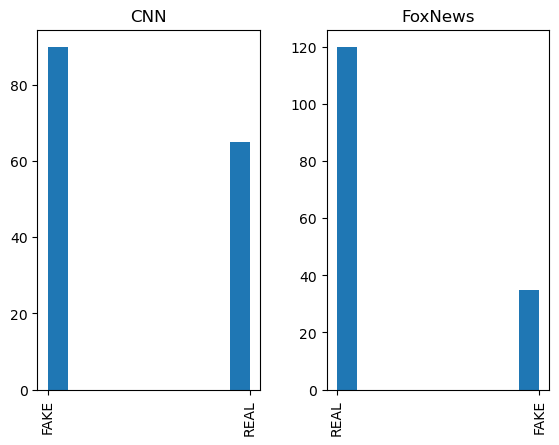

In [68]:
df_both.hist(column="label", by="site")